In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import skimage.transform
%matplotlib inline

In [2]:
def dataset():
    train_dataset = h5py.File('/Users/ananya/Downloads/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('/Users/ananya/Downloads/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:]) 

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_set_x_orig,train_set_y,test_set_x_orig,test_set_y,classes =dataset()

In [4]:
m_train=train_set_x_orig.shape[0]
m_test=test_set_x_orig.shape[0]
num_px=train_set_x_orig.shape[1]

In [5]:
a=train_set_x_orig.shape
b=test_set_x_orig.shape
c=train_set_y.shape
d=test_set_y.shape
print(a,b,c,d)

(209, 64, 64, 3) (50, 64, 64, 3) (1, 209) (1, 50)


In [6]:
train_flatten = (train_set_x_orig.reshape(a[0], -1).T)/255
test_flatten=(test_set_x_orig.reshape(b[0], -1).T)/255

In [7]:
def sigmoid(z):
    s=1/(1+np.exp(-z))
    cache=z
    return s,cache

def relu(z):
    s=np.maximum(0,z)
    cache=z
    return s,cache

def sigmoid_backward(ds,cache):
    z=cache
    l=1/(1+np.exp(-z))
    dz=ds*l*(1-l)
    return dz

def relu_backward(ds,cache):
    dz=np.array(ds,copy=True)
    z=cache
    dz[z<=0]=0
    return dz
    

In [8]:
def initialize_parameters_deep(layer_dims):    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

def linear_forward(s,W,b):
    z = W.dot(s) + b
    cache = (s, W, b) 
    return z, cache


def activation_fn_forward(s_prev,W,b,activation):
    if activation == "sigmoid":
        z, linear_cache = linear_forward(s_prev, W, b)
        s, activation_cache = sigmoid(z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        z, linear_cache = linear_forward(s_prev, W, b)
        s, activation_cache = relu(z)
    cache = (linear_cache, activation_cache)
    return s, cache

def L_model_forward(X,parameters):
    caches = []
    s = X
    L = len(parameters) // 2

    for l in range(1, L):
        s_prev = s 
        s, cache = activation_fn_forward(s_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    AL, cache = activation_fn_forward(s, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    return AL,caches

In [9]:
def compute_cost(AL,Y):
    m=Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost) 
    return cost

In [10]:
def linear_backward(dz,cache):
    s_prev, W, b = cache
    m = s_prev.shape[1]

    dW = 1/m * np.dot(dz,s_prev.T)
    db = 1/m * np.sum(dz, axis = 1, keepdims = True)
    ds_prev = np.dot(W.T,dz)
    return ds_prev,dW,db

def linear_activation_backward(ds, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dz = relu_backward(ds, activation_cache)
        ds_prev, dW, db = linear_backward(dz, linear_cache)
        
    elif activation == "sigmoid":
        dz = sigmoid_backward(ds, activation_cache)
        ds_prev, dW, db = linear_backward(dz, linear_cache)
    
    return ds_prev, dW, db

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["ds" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        ds_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["ds" + str(l + 1)], current_cache, activation = "relu")
        grads["ds" + str(l)] = ds_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [11]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [12]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    probas, caches = L_model_forward(X, parameters)
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("Accuracy: "  + str(np.sum((p == y)/m)))
    print()

In [13]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False): 

    np.random.seed(1)
    costs = []                         
    parameters = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
            costs.append(cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878
Cost after iteration 2500: 0.088413
Cost after iteration 2600: 0.085951


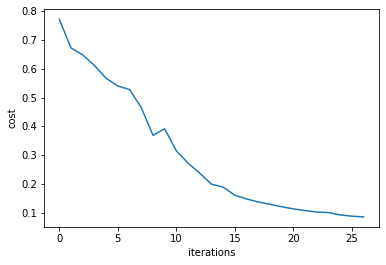

In [14]:
layers_dims = [12288, 20, 7, 5, 1]
parameters = L_layer_model(train_flatten, train_set_y, layers_dims, num_iterations=2700, print_cost=True)

In [20]:
pred_test = predict(test_flatten, test_set_y, parameters)

Accuracy: 0.78



Accuracy: 0.0



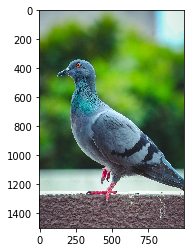

In [15]:
my_image = "/Users/ananya/Downloads/pigeon.jpeg"   
classes=[1]
image = np.array(plt.imread(my_image))
my_image = skimage.transform.resize(image, output_shape=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(my_image,classes, parameters)

plt.imshow(image)
d=str(np.squeeze(my_predicted_image))

Accuracy: 1.0



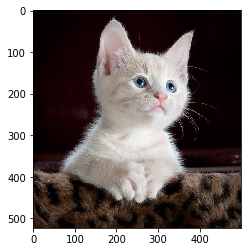

In [16]:
my_image = "/Users/ananya/Downloads/cat.jpeg"   
classes=[1]
image = np.array(plt.imread(my_image))
my_image = skimage.transform.resize(image, output_shape=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(my_image,classes, parameters)

plt.imshow(image)
d=str(np.squeeze(my_predicted_image))